# Automatic Clusterization of Unstructured Property Listings for Psychological Assessments

_Fabián Villena Rodríguez_

## Problem
Property listing task is a psicological assessment where patients have to fill in properties that they think relates to a given concept without naming the concept. These properties are in the form of free text, so the patient can write down without restriction. To further analyse the results, a human must review all properties and then classsify each property into major categories, this process is highly inconsistent and leads to a difficult analysis and possible false conclusions.

## Solution
Automatically cluster the properties without human intervention to systematically group semantically similar concepts into major categories in a consistent manner.

## Hypothesis
A machine learning approach to cluster free-text properties can mimic the human classification classes distribution of these propertier, obtaining similar result in a shorter time.

## Method
To perform the clusterization of the properties, a machine learning approach was applied. The development of the solution was made in Python programming language, using word embeddings to map words into a vector representation of its semantic, to further apply clusterization algorithms to group the properties. The process is explained in the nexs cells.

In [1]:
# %matplotlib inline # plotting the graphs non-interactively
import gensim # module for computing word embeddings
import pandas as pd # more robust data stractures (dataframes)
import numpy as np # linear algebra module
import sklearn.feature_extraction # package to perform tf-idf vertorization
import sklearn.cluster # clusterization algorithms
import sklearn.preprocessing # label encoder 
import sklearn.manifold # dimensionality reduction
import matplotlib.pyplot as plt # visualization
import itertools
pd.set_option('display.max_rows', 100) # make panda show more rows

C:\Users\ville\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format( # loading word embeddings
    r'..\models\SBW-vectors-300-min5.bin', # using the spanish billion words embeddings
    binary=True # the model is in binary format
)

In [4]:
data = pd.read_excel( # loading the data
    r'..\data\raw\Datos Codificados Estudio v2a.xlsx'
)

In [4]:
data = data[[
    'Palabra (concepto)', # the concept asked to the participand
    'Descripción', # property answer of the participand
    'Codificación' # human codification of the property
]]

In [5]:
data = data.applymap(str.lower) # conver to lower case the entire dataframe

In [6]:
data.sample(5) # sample of 5 data points

,Palabra (concepto),Descripción,Codificación
1113,destreza,dicese de una persona que tiene buenas cualida...,cualidades
209,verdad,algo que se piensa y se corrobora empiricamente,pensamiento
3037,éxito,todas las personas lo buscan,humano
1197,decisión,aceptar hacer algo o no,aceptación
3890,acuerdo,planificar hacer algo,plan


In [7]:
data['Descripción'].count() # number of data points

4938

In [8]:
data['Codificación'].value_counts()[data['Codificación'].value_counts() != 1] # number of data points without code

bien                    80
idea                    55
habilidades             52
pensamiento             44
mal                     43
positivo                42
gratitud                41
sentimiento             38
verdad                  37
ayuda                   36
riesgo                  36
mente                   35
angustia                34
capacidad               34
alegría                 33
confianza               31
no mentir               30
deber                   30
elección                30
peligro                 29
felicidad               28
daño                    28
advertencia             28
responsabilidad         28
protección              28
empatía                 28
logro                   27
fe                      27
organización            25
hacer                   25
acción                  24
miedo                   24
tranquilidad            24
emoción                 24
humano                  23
inseguridad             22
correcto                21
n

In [9]:
data['Codificación'].value_counts().count() # number of properties

1294

In [10]:
label_encoder_concepts = sklearn.preprocessing.LabelEncoder() # label encoder maps a group of categprical data to integers
concepts = label_encoder_concepts.fit_transform(data['Palabra (concepto)']) # fitting the label encoding and transforming the concepts column
concepts = np.reshape(concepts, (-1, 1)) # vector transformation for further usage

In [11]:
label_encoder_description = sklearn.preprocessing.LabelEncoder() # label encoder maps a group of categprical data to integers
descriptions = label_encoder_description.fit_transform(data['Descripción']) # fitting the label encoding and transforming the properties column
descriptions = np.reshape(descriptions, (-1, 1)) # vector transformation for further usage

In [12]:
tfidfvectorizer = sklearn.feature_extraction.text.TfidfVectorizer() # instance of the tf-idf vectorizer
tfidfvectorizer.fit_transform(data['Descripción']) # fitting the vectorizer and transforming the properties

<4938x3650 sparse matrix of type '<class 'numpy.float64'>'
	with 19066 stored elements in Compressed Sparse Row format>

In [13]:
idf = {key:val for key,val in zip(tfidfvectorizer.get_feature_names(),tfidfvectorizer.idf_)}

In [14]:
def to_vector(texto,model):
    """ Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence"""
    tokens = texto.split() # splits the text by space and returns a list of words
    vec = np.zeros(300) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if (word in model) & (word in idf): # checks if the word is both in the word embedding and the tf-idf model
            vec += model[word]*idf[word] # adds every word embedding to the vector
    return vec / np.linalg.norm(vec) # divides the vector by their normal

In [15]:
texto = 'pone en riesgo la integridad' # test sentence
to_vector(texto,model)[:30] # example of the first 30 components of the sentence vector

array([-0.02308965, -0.01245489,  0.06393057, -0.00593836,  0.04156472,
        0.06236711, -0.08090533, -0.07934865,  0.08091643, -0.00820033,
        0.11165872, -0.05971171, -0.01205922, -0.0540102 ,  0.01548854,
       -0.02285566, -0.00997002,  0.01797955,  0.03328569,  0.11699641,
        0.03819035, -0.09431122,  0.02962123,  0.0321849 ,  0.05470428,
       -0.02253823, -0.00125454,  0.04004915, -0.01155927,  0.13005375])

In [16]:
descriptions_matrix = np.zeros( # creatign an empty matrix
    (
        len(data), # the number of rows is equal to the number of data points
        len(model['hola']) # the number of columns is equal to the number of components of the word embedding
    )
)

In [17]:
for i,description in enumerate(data['Descripción']):
    vector = to_vector(description,model)
    descriptions_matrix[i,] = vector

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [18]:
label_encoder = sklearn.preprocessing.LabelEncoder()
codes = label_encoder.fit_transform(data['Codificación'])
codes = np.reshape(codes, (-1, 1))

In [19]:
data_matrix = np.concatenate([descriptions_matrix,codes,descriptions,concepts], axis=1)

In [20]:
data_matrix_without_nan = data_matrix[~np.isnan(data_matrix).any(axis=1)]

In [21]:
tisni = sklearn.manifold.TSNE(verbose=True)

In [22]:
tisni.fit(data_matrix_without_nan[:,:300])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4906 samples in 0.045s...
[t-SNE] Computed neighbors for 4906 samples in 9.899s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4906
[t-SNE] Computed conditional probabilities for sample 2000 / 4906
[t-SNE] Computed conditional probabilities for sample 3000 / 4906
[t-SNE] Computed conditional probabilities for sample 4000 / 4906
[t-SNE] Computed conditional probabilities for sample 4906 / 4906
[t-SNE] Mean sigma: 0.237281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.933311
[t-SNE] KL divergence after 1000 iterations: 2.032786


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=True)

In [23]:
# Sum_of_squared_distances = []
# K = range(1,4000,100)
# for k in K:
#     km = sklearn.cluster.KMeans(n_clusters=k,n_jobs=-1)
#     km = km.fit(data_matrix_without_nan[:,:300])
#     Sum_of_squared_distances.append(km.inertia_)

In [24]:
# plt.plot(K, Sum_of_squared_distances)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method For Optimal Number of Clusters')
# plt.show()

In [25]:
kemean = sklearn.cluster.KMeans(n_clusters = 500, n_jobs=-1)
kemean.fit(data_matrix_without_nan[:,:300])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=500, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [26]:
kemean_counts = np.unique(kemean.labels_, return_counts=True)

In [27]:
kemean_counts = np.concatenate([
    np.reshape(kemean_counts[0], (-1, 1)),
    np.reshape(kemean_counts[1], (-1, 1))
], axis=1)

In [28]:
kemean_counts.sort(axis=0)

In [29]:
hier = sklearn.cluster.AgglomerativeClustering(n_clusters = 500)
hier.fit(data_matrix_without_nan[:,:300])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=500,
                        pooling_func='deprecated')

In [30]:
hier_counts = np.unique(hier.labels_, return_counts=True)

In [31]:
hier_counts = np.concatenate([
    np.reshape(hier_counts[0], (-1, 1)),
    np.reshape(hier_counts[1], (-1, 1))
], axis=1)

In [32]:
hier_counts.sort(axis=0)

In [33]:
debescan = sklearn.cluster.DBSCAN(eps=0.1, min_samples=5)
debescan.fit(tisni.embedding_)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [34]:
debescan_counts = np.unique(debescan.labels_[debescan.labels_ != -1], return_counts=True)

In [35]:
debescan_counts = np.concatenate([
    np.reshape(debescan_counts[0], (-1, 1)),
    np.reshape(debescan_counts[1], (-1, 1))
], axis=1)

In [36]:
debescan_counts.sort(axis=0)

In [37]:
optic = sklearn.cluster.OPTICS(
    metric='minkowski',
    n_jobs=-1
)
optic.fit(tisni.embedding_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\optics_.py:795: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=None, min_samples=5, n_jobs=-1, p=2,
       predecessor_correction=True, xi=0.05)

In [38]:
optic_counts = np.unique(optic.labels_[optic.labels_ != -1], return_counts=True)

In [39]:
optic_counts = np.concatenate([
    np.reshape(optic_counts[0], (-1, 1)),
    np.reshape(optic_counts[1], (-1, 1))
], axis=1)

In [40]:
optic_counts.sort(axis=0)

## Results
The clusterization by clusterization method is shown in the next figure.

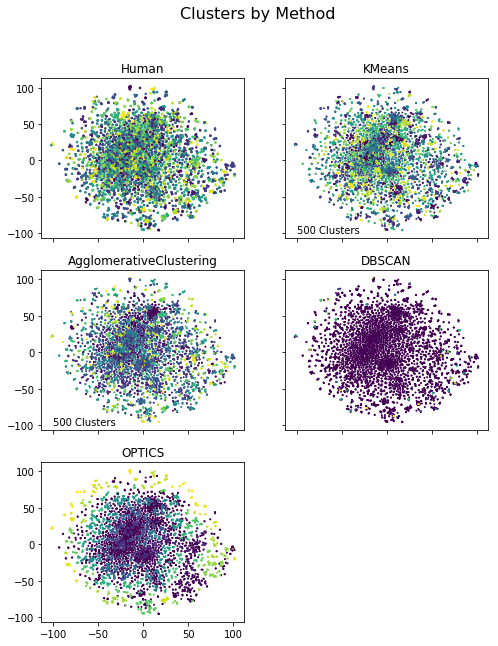

In [41]:
fig, axs = plt.subplots(
    3, 2, 
    sharex=True, 
    sharey=True
)
fig.set_size_inches(8, 10)
fig.suptitle('Clusters by Method', fontsize=16)
axs[0, 0].set_title('Human')
axs[0,0].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = data_matrix_without_nan[:,300],
    s = 2
           )
axs[0, 1].set_title('KMeans')
axs[0, 1].text(-100, -100, '500 Clusters')
axs[0,1].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = kemean.labels_,
    s = 1
           )
axs[1, 0].set_title('AgglomerativeClustering')
axs[1, 0].text(-100, -100, '500 Clusters')
axs[1,0].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = hier.labels_,
    s = 1
           )
axs[1, 1].set_title('DBSCAN')
axs[1,1].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = debescan.labels_,
    s = 1
           )
axs[2, 0].set_title('OPTICS')
axs[2,0].scatter(
    tisni.embedding_[:,0],
    tisni.embedding_[:,1],
    c = optic.labels_,
    s = 1
           )
fig.delaxes(axs[2,1])
plt.show()

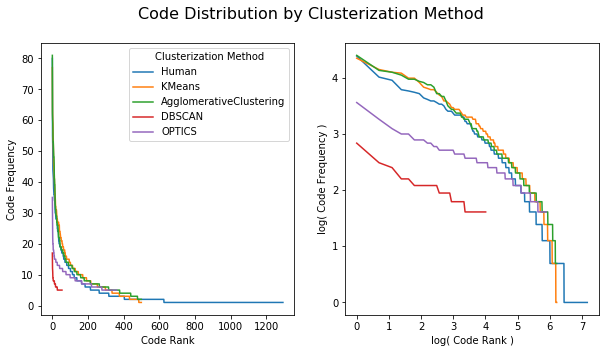

In [42]:
fig, axs = plt.subplots(
    1, 2, 
    sharex=False, 
    sharey=False
)
fig.suptitle('Code Distribution by Clusterization Method', fontsize=16)
fig.set_size_inches(10, 5)
axs[0].plot(
    data['Codificación'].value_counts().values,
    label='Human'
)
axs[1].plot(
    np.log(list(range(1,len(data['Codificación'].value_counts().values)+1))),
    np.log(data['Codificación'].value_counts().values),
    label='Human'
)
axs[0].plot(
    kemean_counts[::-1][:,1],
    label='KMeans'
)
axs[1].plot(
    np.log(list(range(1,len(kemean_counts[::-1][:,1])+1))),
    np.log(kemean_counts[::-1][:,1]),
    label='KMeans'
)
axs[0].plot(
    hier_counts[::-1][:,1],
    label='AgglomerativeClustering'
)
axs[1].plot(
    np.log(list(range(1,len(hier_counts[::-1][:,1])+1))),
    np.log(hier_counts[::-1][:,1]),
    label='AgglomerativeClustering'
)
axs[0].plot(
    debescan_counts[::-1][:,1],
    label='DBSCAN'
)
axs[1].plot(
    np.log(list(range(1,len(debescan_counts[::-1][:,1])+1))),
    np.log(debescan_counts[::-1][:,1]),
    label='DBSCAN'
)
axs[0].plot(
    optic_counts[::-1][:,1],
    label='OPTICS'
)
axs[1].plot(
    np.log(list(range(1,len(optic_counts[::-1][:,1])+1))),
    np.log(optic_counts[::-1][:,1]),
    label='OPTICS'
)
axs[0].set_ylabel('Code Frequency')
axs[0].set_xlabel('Code Rank')
axs[1].set_ylabel('log( Code Frequency )')
axs[1].set_xlabel('log( Code Rank )')
axs[0].legend(title="Clusterization Method")

In [43]:
all_codes = np.concatenate([data_matrix_without_nan[:,300:],
                np.reshape(kemean.labels_, (-1, 1)),
                np.reshape(hier.labels_, (-1, 1)),
                np.reshape(debescan.labels_, (-1, 1)),
                np.reshape(optic.labels_, (-1, 1)),
               ],axis=1).astype(int)

In [44]:
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

In [45]:
codes_comparison = pd.DataFrame(
    all_codes,columns=['Human','Property','Concept','KMeans','AgglomerativeClustering','DBSCAN','OPTICS']
)
codes_comparison['Human'] = label_encoder.inverse_transform(codes_comparison.Human)
codes_comparison['Property'] = label_encoder_description.inverse_transform(codes_comparison.Property)
codes_comparison['Concept'] = label_encoder_concepts.inverse_transform(codes_comparison.Concept)

KMeans_dict = codes_comparison[['Human','KMeans']].groupby(by='KMeans')['Human'].apply(list).to_dict()
KMeans_categories = {}
for key, val in KMeans_dict.items():
    KMeans_categories[key] = most_frequent(val)
    
AgglomerativeClustering_dict = codes_comparison[['Human','AgglomerativeClustering']].groupby(by='AgglomerativeClustering')['Human'].apply(list).to_dict()
AgglomerativeClustering_categories = {}
for key, val in AgglomerativeClustering_dict.items():
    AgglomerativeClustering_categories[key] = most_frequent(val)

DBSCAN_dict = codes_comparison[['Human','DBSCAN']].groupby(by='DBSCAN')['Human'].apply(list).to_dict()
DBSCAN_categories = {}
for key, val in DBSCAN_dict.items():
    if key == -1:
        DBSCAN_categories[key] = 'outlier'
    else:
        DBSCAN_categories[key] = most_frequent(val)

OPTICS_dict = codes_comparison[['Human','OPTICS']].groupby(by='OPTICS')['Human'].apply(list).to_dict()
OPTICS_categories = {}
for key, val in OPTICS_dict.items():
    if key == -1:
        OPTICS_categories[key] = 'outlier'
    else:
        OPTICS_categories[key] = most_frequent(val)

codes_comparison['KMeans'] = codes_comparison['KMeans'].map(KMeans_categories)
codes_comparison['AgglomerativeClustering'] = codes_comparison['AgglomerativeClustering'].map(AgglomerativeClustering_categories)
codes_comparison['DBSCAN'] = codes_comparison['DBSCAN'].map(DBSCAN_categories)
codes_comparison['OPTICS'] = codes_comparison['OPTICS'].map(OPTICS_categories)

In [46]:
codes_distribution = codes_comparison.Human.value_counts().reset_index()
codes_distribution.columns = ['Human','frequency']

Example of the clusterization of the properties of the word _honestidad_ by clusterization method. The label _-1_ represents the data points which have no cluster in the density based methods.

In [47]:
codes_comparison.sort_values(
    by=['KMeans'], ascending=False
)[
    codes_comparison.Concept == 'honestidad'
][
    ['Property','Human', 'KMeans', 'AgglomerativeClustering', 'DBSCAN', 'OPTICS']
]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Property,Human,KMeans,AgglomerativeClustering,DBSCAN,OPTICS
2725,virtud,virtud,virtud,virtud,outlier,virtud
1781,virtud,virtud,virtud,virtud,outlier,virtud
4232,es una virtud,virtud,virtud,virtud,outlier,virtud
3924,virtud,virtud,virtud,virtud,outlier,virtud
465,se asocia al color blanco,blanco,verde,verde,outlier,verde
2563,expresa la verdad,verdad,verdad,afirmación,outlier,verdad
2726,consiste en decir la verdad,verdad,verdad,futuro,outlier,verdad
795,verdad,verdad,verdad,verdad,verdad,verdad
4605,decir la verdad,verdad,verdad,verdad,outlier,verdad
3261,se dice la verdad,verdad,verdad,perdón,outlier,verdad


In [50]:
codes_comparison.sort_values(
    by=['KMeans'], ascending=False
)[
    codes_comparison.Human == 'logro'
][
    ['Property','Human', 'KMeans', 'AgglomerativeClustering', 'DBSCAN', 'OPTICS']
]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Property,Human,KMeans,AgglomerativeClustering,DBSCAN,OPTICS
1215,forma de medida del logro,logro,término,decisión,outlier,logro
882,todos lo quieren lograr,logro,todos,felicidad,outlier,logro
3935,todos podemos lograrlo,logro,todos,aprovechar,outlier,logro
3017,sucede a un logro,logro,suceso,logro,outlier,logro
1213,se les dice a las personas que tienen una vida...,logro,personal/grupal,ayuda,outlier,outlier
4570,se logra cuando la realidad coincide con tus d...,logro,padres,esfuerzo,outlier,outlier
1214,lograr un objetivo,logro,objetivos,objetividad,outlier,objetivos
1751,lograr objetivo,logro,objetivos,objetividad,outlier,objetivos
4512,lograr un objetivo,logro,objetivos,objetividad,outlier,objetivos
2699,los mejores lo logran,logro,no todos,felicidad,outlier,no resultados


## Discussion

Using as a gold standard the human codification, the most similar frequency distribution of codes are the KMeans and Hierarchical Clustering methods using 500 clusters. This pseudo-logarithmic distribution can be associated with Zipf law which states that in some physical and social phenomena the frequency of an event is inversely proportional to their rank. The distribution described here could be associated with the distribution of words in the natural language itself and not necessarily associated with this specific property listing task.

Using the density based methods for clusterization a non-logarithmic distribution was found. Making a cuantitative analysis of the clusterization made by this methods, a more granular grouping of terms is found. This more granular codification could extract more topic specific information because it is not grouping a large number of properties on a single big category.

## Conclusion
Using unsupervised machine learning methods, the codification of property listing tasks can be made whithout human intervention achieving a human-coded distribution of codes.